![image source: https://www.artbreeder.com/image/6b4df6c697078f0e2cda42348ec6](images/2025-02-15-diffusion-model-mnist-part2.jpeg)

## Introduction

Welcome back to Part 2 of our journey into diffusion models! In the [first part](https://hassaanbinaslam.github.io/myblog/posts/2025-02-10-diffusion-model-mnist-part1.html), we successfully built a basic Convolutional UNet from scratch and trained it to directly predict denoised MNIST digits.  We saw that it could indeed remove some noise, but the results were still a bit blurry, and it wasn't quite the "diffusion model magic" we were hoping for.

One of the key limitations we hinted at was the simplicity of our `BasicUNet` architecture.  For this second part, we're going to address that and we'll be upgrading our UNet architecture to something more powerful and feature-rich.

To do this, we'll be leveraging the fantastic `diffusers` library from [Hugging Face](https://huggingface.co/).  [`diffusers`](https://huggingface.co/docs/diffusers/en/index) is a widely adopted toolkit in the world of diffusion models, providing pre-built and optimized components that can significantly simplify our development process and boost performance.

In this part, we'll replace our `BasicUNet` with a `UNet2DModel` from `diffusers`.  We'll keep the core task the same – direct image prediction – but with a more advanced UNet under the hood. This will allow us to see firsthand how architectural improvements can impact the quality of our denoising results, setting the stage for even more exciting explorations in future parts! Let's dive in!

### Credits

This post is inspired by the [Hugging Face Diffusion Course](https://huggingface.co/learn/diffusion-course/en/unit1/3)

### Environment Details

You can access and run this Jupyter Notebook from the GitHub repository on this link [2025-02-15-diffusion-model-mnist-part2.ipynb](https://github.com/hassaanbinaslam/myblog/blob/main/posts/2025-02-15-diffusion-model-mnist-part2.ipynb)

Run the following cell to install the required packages.

* This notebook can be run with [Google Colab](https://colab.research.google.com/) T4 GPU runtime.
* I have also tested this notebook with AWS SageMaker Jupyter Notebook running on instance "ml.g5.xlarge" and image "SageMaker Distribution 2.3.0".

In [1]:
%%capture
!pip install datasets[vision]
!pip install diffusers
!pip install watermark
!pip install torchinfo
!pip install matplotlib

[WaterMark](https://github.com/rasbt/watermark) is an IPython magic extension for printing date and time stamps, version numbers, and hardware information. Let's load this extension and print the environment details.

In [2]:
%load_ext watermark

In [3]:
%watermark -v -m -p torch,torchvision,datasets,diffusers,matplotlib,watermark,torchinfo

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 7.34.0

torch      : 2.5.1+cu124
torchvision: 0.20.1+cu124
datasets   : 3.3.0
diffusers  : 0.32.2
matplotlib : 3.10.0
watermark  : 2.5.0
torchinfo  : 1.8.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.1.85+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



## Diving into `diffusers` and `UNet2DModel`

So, what exactly *is* this [`diffusers`](https://huggingface.co/docs/diffusers/en/index) library we're so excited about?  Think of `diffusers` as a comprehensive, community-driven library in [PyTorch](https://pytorch.org/) specifically designed for working with diffusion models. It's maintained by Hugging Face, the same team behind the popular [Transformers](https://huggingface.co/docs/transformers/en/index) library, so you know it's built with quality and ease of use in mind.

Why are we using `diffusers` now?  Several reasons!  First, it provides well-tested and optimized implementations of various diffusion model components, saving us from writing everything from scratch.  Second, it's a vibrant ecosystem, constantly evolving with the latest research and techniques in diffusion models.  By using `diffusers`, we're standing on the shoulders of giants!

For Part 2, the star of the show is the [`UNet2DModel`](https://huggingface.co/docs/diffusers/main/en/api/models/unet2d) class from `diffusers`. This is a more sophisticated UNet architecture compared to our `BasicUNet`.  It's like upgrading from a standard bicycle to a mountain bike – both are bikes, but the mountain bike is built for more challenging terrain and better performance.

What makes `UNet2DModel` more advanced? Let's look at some key architectural improvements under the hood:

*   **ResNet Blocks:**  Instead of simple convolutional layers, `UNet2DModel` utilizes ResNet blocks within its downsampling and upsampling paths. ResNet blocks are known for making it easier to train deeper networks, which can capture more complex features in images. Think of them as more efficient and powerful building blocks for our UNet.

*   **Attention Mechanisms:**  `UNet2DModel` incorporates attention mechanisms, specifically "Attention Blocks," in its architecture.  Attention is a powerful concept in deep learning that allows the model to focus on the most relevant parts of the input when processing information.  In image generation, attention can help the model selectively focus on different regions of the image, potentially leading to finer details and more coherent structures.

*   **Group Normalization:**  Instead of Batch Normalization, `UNet2DModel` uses Group Normalization. Group Normalization is often favored in generative models, especially when working with smaller batch sizes, as it tends to be more stable and perform better in those scenarios.

*   **Timestep Embedding:**  Even though we are still doing direct image prediction in this part,  `UNet2DModel` is designed with diffusion models in mind.  It includes a `TimestepEmbedding` layer, which is a standard component in diffusion models to handle the timestep information (which we'll explore in later parts!).  For now, we'll just be passing in a timestep of 0, but this layer is there, ready for when we move to true diffusion.

These architectural enhancements in `UNet2DModel` give it a greater capacity to learn and potentially denoise images more effectively than our `BasicUNet`. Let's see if it lives up to the hype!

## Data Preparation and Preprocessing for MNIST

As we are building upon the foundations laid in [Part 1](https://hassaanbinaslam.github.io/myblog/posts/2025-02-10-diffusion-model-mnist-part1.html), we will reuse the same data preparation and preprocessing steps for the MNIST dataset. For a more in-depth explanation of these steps, please refer back to the first part of this guide. Here, we will quickly outline the process to ensure our data is ready for training our enhanced UNet.

First, we load the MNIST dataset using the `datasets` library:

In [4]:
from datasets import load_dataset
dataset = load_dataset("mnist")
print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md:   0%|          | 0.00/6.97k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})


This code snippet downloads and loads the MNIST dataset.  As we saw in [Part 1](https://hassaanbinaslam.github.io/myblog/posts/2025-02-10-diffusion-model-mnist-part1.html), this dataset is provided as a `DatasetDict` with 'train' and 'test' splits, each containing 'image' and 'label' features.

Next, we define our preprocessing pipeline using `torchvision.transforms`:

In [5]:
import torch
from torchvision import transforms

image_size = 32  # Define the target image size

preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

This `preprocess` pipeline consists of two transformations:

*   `transforms.Resize((image_size, image_size))`: Resizes each image to a fixed size of 32x32 pixels. This ensures consistent input dimensions for our UNet model.
*   `transforms.ToTensor()`: Converts the images to PyTorch tensors and scales the pixel values to the range \[0, 1]. This normalization is crucial for training deep learning models effectively.

To apply this preprocessing to the dataset efficiently, we define a `transform` function and set it for our dataset:

In [6]:
# Define the transform function
def transform(examples):
    examples = [preprocess(image) for image in examples["image"]]
    return {"images": examples}

# Apply the transform to the dataset
dataset.set_transform(transform)

This `transform` function applies our `preprocess` pipeline to each image in the dataset on-the-fly, meaning preprocessing happens only when the data is accessed, saving memory and keeping our dataset efficient.

Finally, we need the noise corruption function that we introduced in Part 1. This function will be used to add controlled noise to our clean MNIST images during training, simulating the forward diffusion process:

In [7]:
# Definition of the noise corruption function
def corrupt(x, noise, amount):
    amount = amount.view(-1, 1, 1, 1)  # make sure it's broadcastable
    return (
        x * (1 - amount) + noise * amount
    )  # equivalent to x.lerp(noise, amount)

This `corrupt` function takes a clean image (`x`), random noise (`noise`), and a noise `amount` (ranging from 0 to 1) as input. It then blends the clean image with the noise based on the `amount`, effectively creating a noisy version of the image.  The higher the `amount`, the more noise is added.

With the MNIST dataset loaded, preprocessed, and the noise corruption function defined, we are now fully prepared to train our enhanced UNet architecture from the `diffusers` library! Let's move on to explore the `UNet2DModel`.

## Model 2: Implementing `UNet2DModel`

Now, let's see how to put the `diffusers` `UNet2DModel` into action for our MNIST digit denoising task.  Here's the code snippet we'll use to instantiate the model:

In [8]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=32,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(32, 64, 64),
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
    ),
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [9]:
print(model)

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

In [10]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                        Param #
UNet2DModel                                   --
├─Conv2d: 1-1                                 320
├─Timesteps: 1-2                              --
├─TimestepEmbedding: 1-3                      --
│    └─Linear: 2-1                            4,224
│    └─SiLU: 2-2                              --
│    └─Linear: 2-3                            16,512
├─ModuleList: 1-4                             --
│    └─DownBlock2D: 2-4                       --
│    │    └─ModuleList: 3-1                   45,504
│    │    └─ModuleList: 3-2                   9,248
│    └─AttnDownBlock2D: 2-5                   --
│    │    └─ModuleList: 3-3                   33,536
│    │    └─ModuleList: 3-4                   148,352
│    │    └─ModuleList: 3-5                   36,928
│    └─AttnDownBlock2D: 2-6                   --
│    │    └─ModuleList: 3-6                   33,536
│    │    └─ModuleList: 3-7                   164,736
├─ModuleList: 1-5          

::: {.callout-note}

Our model based on diffuser library UNet2DModel has 5x more trainable parameters as compared to Basic Convolutional UNet Model from Part 1.

:::

Let's break down the parameters we've used when creating our `UNet2DModel` instance:

*   `sample_size=32`:  This specifies the size of the input images. We're still working with 32x32 MNIST images after preprocessing, so we set this to 32.
*   `in_channels=1`: MNIST images are grayscale, meaning they have a single color channel.  Therefore, `in_channels` is set to 1.
*   `out_channels=1`:  We want our UNet to output denoised grayscale images, so `out_channels` is also 1.
*   `layers_per_block=2`: This parameter controls the number of ResNet layers within each UNet block (both downsampling and upsampling blocks). We've chosen 2, meaning each block will have two ResNet layers. Increasing this would make the model deeper and potentially more powerful, but also increase training time.
*   `block_out_channels=(32, 64, 64)`: This is a crucial parameter that defines the number of output channels for each block in the downsampling path.
    *   The first value, `32`, corresponds to the output channels of the initial downsampling block.
    *   The second value, `64`, is for the next downsampling block, and so on.
    *   We've chosen `(32, 64, 64)`, which is "roughly matching our basic unet example" as we noted in the code comments. This is a deliberate choice to keep the model size somewhat comparable to our `BasicUNet` while still benefiting from the architectural improvements of `UNet2DModel`.

*   `down_block_types=("DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D")`: This list specifies the type of downsampling blocks to use in the encoder path.
    *   `"DownBlock2D"`:  A standard ResNet downsampling block.
    *   `"AttnDownBlock2D"`: A ResNet downsampling block with added attention mechanisms.
    *   We're using a mix of standard and attention-based downsampling blocks to leverage the benefits of attention in capturing important image features.

*   `up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D")`:  Similarly, this list defines the types of upsampling blocks in the decoder path, mirroring the downsampling path and also incorporating attention blocks in the upsampling process.

By carefully configuring these parameters, we've created a `UNet2DModel` tailored for our MNIST denoising task, leveraging the power of `diffusers` and incorporating more advanced architectural components compared to our `BasicUNet`.  The `print(model)` output (or `summary(model)`) will show the detailed architecture and confirm the parameter settings we've defined.  You'll likely notice a significantly larger number of parameters compared to `BasicUNet`, hinting at the increased capacity of this enhanced model.

### Training the Enhanced UNet

With our `UNet2DModel` defined, the next step is to train it!  The training process for this enhanced UNet will be remarkably similar to what we did in Part 1 with our `BasicUNet`.  This is intentional! By keeping the training process consistent, we can isolate the impact of the architectural changes we've made by switching to `UNet2DModel`.

We will still be using:

*   **Direct Image Prediction:**  Our model will still be trained to directly predict the denoised version of a noisy MNIST image in a single forward pass.
*   **Mean Squared Error (MSE) Loss:** We'll continue to use MSE loss (`F.mse_loss`) to measure the difference between the predicted denoised image and the clean target image.
*   **Adam Optimizer:**  We'll stick with the Adam optimizer (`torch.optim.Adam`) to update the model's weights during training.

Here's a snippet of the training loop code. You'll notice it's almost identical to the training loop from Part 1:

In [11]:
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt

# --- Setup (Device, Model, Optimizer, Loss History, Hyperparameters) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device) # Our UNet2DModel from diffusers
optimizer = Adam(model.parameters(), lr=1e-3) # Same learning rate as Part 1
losses = []
num_epochs = 5 # Same number of epochs as Part 1
batch_size = 128 # Same batch size as Part 1

train_dataloader = torch.utils.data.DataLoader(
    dataset["train"], batch_size=batch_size, shuffle=True
)

print(device)

cuda


In [12]:
# --- Training Loop ---
for epoch in range(num_epochs):
    for batch in train_dataloader:
        clean_images = batch["images"].to(device)
        noise = torch.rand_like(clean_images).to(device)
        noise_amount = torch.randn(clean_images.shape[0]).to(device)
        noisy_images = corrupt(clean_images, noise, noise_amount) # Same corrupt function

        predicted_images = model(noisy_images, 0).sample # Still passing timestep 0

        loss = F.mse_loss(predicted_images, clean_images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    avg_loss = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {avg_loss:.4f}")

Epoch 1/5 - Average Loss: 0.0130
Epoch 2/5 - Average Loss: 0.0073
Epoch 3/5 - Average Loss: 0.0062
Epoch 4/5 - Average Loss: 0.0058
Epoch 5/5 - Average Loss: 0.0055


As you can see, the core training logic remains the same. We load batches, generate noise, corrupt images, feed them to the `UNet2DModel` (still with a timestep of 0), calculate MSE loss, and update the weights using Adam.  We've also kept the hyperparameters (learning rate, batch size, number of epochs) consistent with Part 1 for a direct comparison.

After running this training code, we obtain the following loss curve:

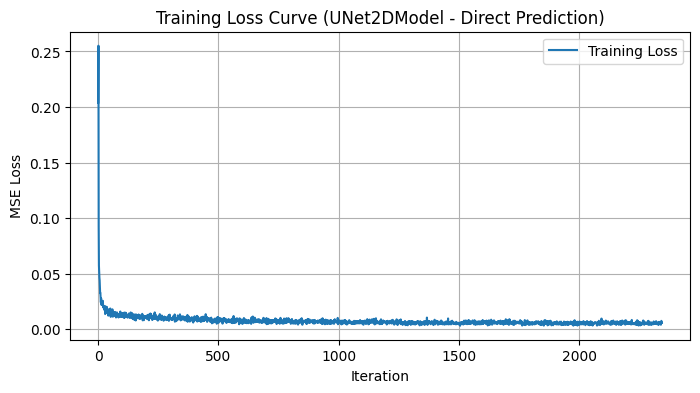

In [13]:
# --- Plotting Loss Curve ---
plt.figure(figsize=(8, 4))
plt.plot(losses, label="Training Loss")
plt.title("Training Loss Curve (UNet2DModel - Direct Prediction)") # Updated title
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

Now that our enhanced UNet is trained, let's see how it performs in denoising MNIST digits!

### Inference and Results: Did `diffusers` UNet Improve Things?

Now comes the crucial question: Did upgrading to `UNet2DModel` actually improve our denoising performance compared to the `BasicUNet` from Part 1?  To find out, we need to evaluate our trained `UNet2DModel` on unseen MNIST test data.

We'll follow a similar inference process as in Part 1.  We'll load a batch of test images, generate noisy versions of them using the same `corrupt` function, feed these noisy images into our trained `UNet2DModel`, and then visualize the results.

Here's the code for inference and visualization:

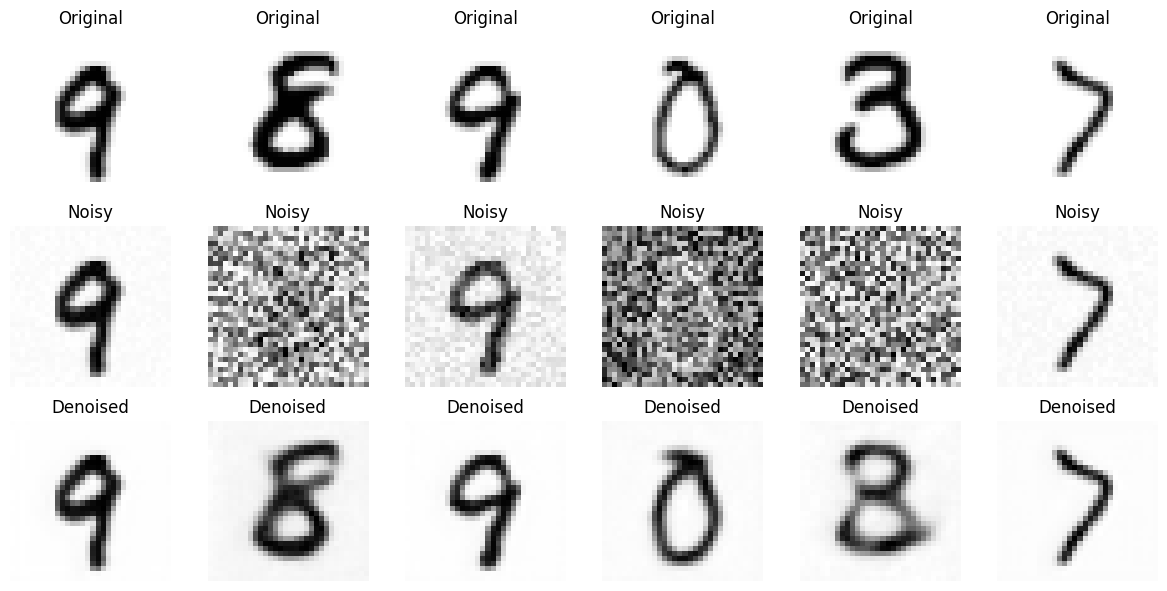

In [14]:
# --- Inference with Model 1 and Visualization ---
# --- Prepare test dataset and dataloader ---
test_dataset = load_dataset("mnist", split="test") # Load MNIST test split dataset
test_dataset.set_transform(transform)             # Apply preprocessing transform to test dataset
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True) # Create DataLoader for test dataset

# --- Get a batch of test images ---
batch = next(iter(test_dataloader))
clean_images = batch["images"].to(device) # Load clean test images to the device

# --- Generate new random noise for inference ---
noise = torch.rand_like(clean_images).to(device) # Generate random noise tensor
noise_amount = torch.randn(clean_images.shape[0]).to(device) # Generate noise amount tensor
noisy_images = corrupt(clean_images, noise, noise_amount) # Create noisy test images by corruption

# --- Perform inference (get denoised images from Model 1) ---
model.eval()  # Set model to evaluation mode for inference
with torch.no_grad():  # Disable gradient calculation during inference
    denoised_images = model(noisy_images, 0) # Get denoised images from model

# --- Move tensors to CPU and convert to NumPy for visualization ---
noisy_images_np = noisy_images.cpu().numpy() # Move noisy images to CPU and convert to NumPy
denoised_images_np = denoised_images["sample"].cpu().numpy() # Move denoised images to CPU and convert to NumPy
clean_images_np = clean_images.cpu().numpy() # Move clean images to CPU and convert to NumPy

# --- Plotting the results: Original, Noisy, Denoised ---
num_images = 6  # Set number of images to visualize
plt.figure(figsize=(12, 6)) # Initialize matplotlib figure for plotting

for i in range(num_images): # Loop through number of images to plot
    # --- Plot Original (Clean) Images ---
    plt.subplot(3, num_images, i + 1) # Create subplot for original images (top row)
    plt.imshow(clean_images_np[i].squeeze(), cmap='Greys') # Display original clean image
    plt.title("Original") # Set title for original image subplot
    plt.axis('off') # Hide axes for cleaner image display

    # --- Plot Noisy Images ---
    plt.subplot(3, num_images, i + num_images + 1) # Create subplot for noisy images (middle row)
    plt.imshow(noisy_images_np[i].squeeze(), cmap='Greys') # Display noisy image input
    plt.title("Noisy") # Set title for noisy image subplot
    plt.axis('off') # Hide axes

    # --- Plot Denoised Images ---
    plt.subplot(3, num_images, i + 2 * num_images + 1) # Create subplot for denoised images (bottom row)
    plt.imshow(denoised_images_np[i].squeeze(), cmap='Greys') # Display denoised output image
    plt.title("Denoised") # Set title for denoised image subplot
    plt.axis('off') # Hide axes

plt.tight_layout() # Adjust subplot layout for better spacing
plt.show() # Show the complete plot

Now, let's analyze the results visually.  Looking at the "Denoised (UNet2DModel Output)" row (bottom row), and comparing it to the "Noisy (Input)" row (middle row), we can observe that the `UNet2DModel` is indeed denoising the digits. The random noise is significantly reduced, and the digit shapes become much clearer.

**However, the key question is: Is it *better* than `BasicUNet`?**

*   **Sharpness:** Are the denoised digits from `UNet2DModel` sharper and more well-defined compared to `BasicUNet`?
*   **Blurriness:** Is there less residual blurriness in the `UNet2DModel` outputs?
*   **Artifacts/Noise:** Are there fewer artifacts or less remaining noise in the background or around the digits generated by `UNet2DModel`?
*   **Overall Visual Quality:**  Subjectively, do the denoised digits from `UNet2DModel` look more like clean MNIST digits compared to `BasicUNet`?

Upon visual inspection, the denoised digits from `UNet2DModel` appear to be noticeably sharper and more defined than those from `BasicUNet` in Part 1.  The residual blurriness seems reduced, and the digits have a slightly cleaner appearance.  While not perfectly restored, the `UNet2DModel` outputs do seem to represent a step up in visual quality compared to our baseline model.


Let's run inference one more time, but with a different approach.  

Instead of starting with an original **MNIST digit** and adding noise to it, we will feed the model **pure noise** as input and observe the results.

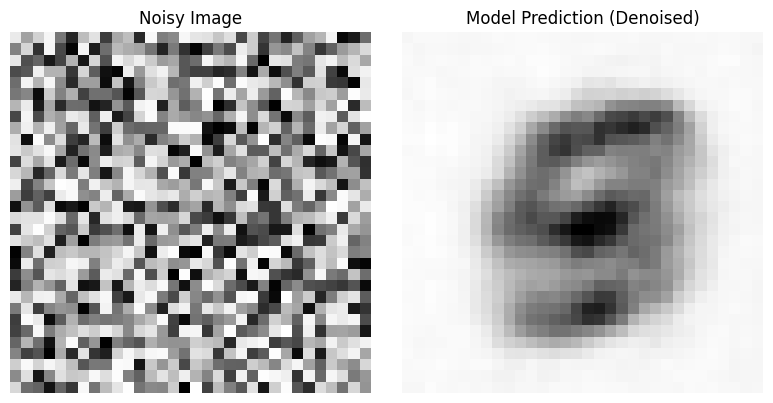

In [15]:
import torch
import matplotlib.pyplot as plt

# Generate a noisy image (random noise)
noise_image = torch.rand(1, 32, 32)  # Example: Single-channel (grayscale) 32x32 noise image

# Assume `model` is trained and available
with torch.no_grad():
    denoised_image = model(noise_image.unsqueeze(0).to(device), 0)  # Add batch dimension & move to device
    denoised_image = denoised_image["sample"].squeeze(0).cpu().detach()  # Remove batch dim & move to CPU

# Plot both images side by side
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(noise_image.squeeze(), cmap="Greys")
axs[0].set_title("Noisy Image")
axs[0].axis("off")

axs[1].imshow(denoised_image.squeeze(), cmap="Greys")
axs[1].set_title("Model Prediction (Denoised)")
axs[1].axis("off")

plt.tight_layout()
plt.show()

In summary, our initial visual assessment suggests that enhancing our UNet architecture by using `UNet2DModel` from `diffusers` has led to an improvement in denoising performance for direct image prediction.  The more sophisticated architecture, seems to be better at capturing and removing noise while preserving digit details.

However, let's push this further and see if iterative refinement can further enhance the quality of images generated by our `UNet2DModel`!

### Exploring Iterative Refinement (Again)

At the end of Part 1, we experimented with a simple iterative refinement approach to see if we could further improve the denoising results from our `BasicUNet`. We found that by repeatedly applying the model in steps, we could nudge the image towards a cleaner state. Now, let's revisit this iterative refinement strategy, but this time using our enhanced `UNet2DModel`.

The idea is the same: instead of just denoising in a single shot, we'll start with pure random noise and iteratively refine it over multiple steps using our trained `UNet2DModel`.  The following code performs iterative refinement over `n_steps` (set to 5 in this example). In each step, we feed the current image `x` (initially random noise) into our `UNet2DModel` to get a prediction. We then blend this prediction with the current image `x` using a linear interpolation, gradually refining the image towards the model's predictions. We also track the image at each step (`step_history`) and the model's direct predictions (`pred_output_history`) for visualization.

Running this iterative refinement code with our `UNet2DModel` produces the following visualization:

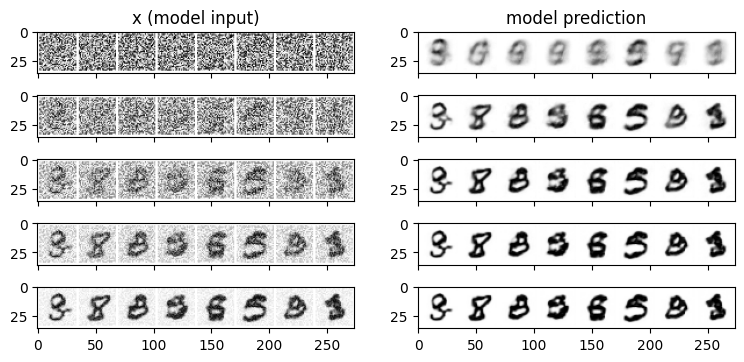

In [16]:
import torchvision
from matplotlib import pyplot as plt

n_steps = 5
x = torch.rand(8, 1, 32, 32).to(device)  # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    # Predict denoise image
    with torch.no_grad():
        pred = model(x, 0).sample

    # Store output for plotting
    pred_output_history.append(pred.detach().cpu())

    # Move slightly towards that direction
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor

    # Store output for plotting
    step_history.append(x.detach().cpu())

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0, 0].set_title("x (model input)")
axs[0, 1].set_title("model prediction")
for i in range(n_steps):
    axs[i, 0].imshow(
        torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap="Greys"
    )
    axs[i, 1].imshow(
        torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1),
        cmap="Greys",
    )

Let's analyze the results.  Looking at the left column, "x (Model Input)," which shows the image at each refinement step, we can observe how the initially random noise gradually transforms into recognizable digit-like structures over the 5 steps.

Now, let's compare these iteratively refined results to: Iterative Refinement with `BasicUNet`

::: {layout-ncol=2}
![BasicUNet](images/2025-02-15-diffusion-model-mnist-part2/basicunetmodel-output.png)

![UNet2DModel](images/2025-02-15-diffusion-model-mnist-part2/unet2dmodel-output.png)
:::

We can see a subtle but noticeable improvement in `UNet2DModel` image quality. This suggests that `UNet2DModel` iterative refinement can still be a valuable technique to squeeze out a bit more image quality for direct image prediction. However, it's crucial to remember that this iterative process is still a simplification.  It is not representative of true diffusion model sampling. We are essentially manually guiding the image towards a cleaner state by repeatedly using our direct prediction model, rather than implementing the probabilistic reverse diffusion process that is at the heart of true diffusion models.

In the next and final part of this series, we will finally move beyond direct image prediction and delve into the core principles of diffusion models: noise prediction and scheduled denoising.  This will unlock the true power and flexibility of diffusion models for image generation!

## Discussion and Key Takeaways

In Part 2, we took a significant step forward by enhancing our UNet architecture. By replacing our `BasicUNet` with the `UNet2DModel` from the `diffusers` library, we aimed to improve the quality of our MNIST digit denoising through direct image prediction.

Our experiments and visual analysis suggest the following key takeaways:

*   **`UNet2DModel` Shows Improvement:**  Visually, the `UNet2DModel` does appear to denoise MNIST digits more effectively than our `BasicUNet` from Part 1.
*   **Iterative Refinement Still Helps:**  Even with the enhanced `UNet2DModel`, we found that iterative refinement could still further improve the visual quality of the denoised digits, leading to slightly sharper and more well-formed digits. This reinforces the idea that even with a better model, iterative approaches can be a useful strategy to refine outputs in direct prediction scenarios.
*   **`diffusers` is a Powerful Tool:**  This part highlighted the value of using libraries like `diffusers`.  By leveraging `UNet2DModel`, we were able to quickly implement a more advanced UNet architecture without having to build it from scratch. `diffusers` provides a rich set of pre-built, optimized components that can significantly accelerate diffusion model development and experimentation.
*   **Direct Prediction is Limited:**  Despite the improvements with `UNet2DModel`, it's crucial to remember that we are still working within the paradigm of *direct image prediction*.  While we can achieve some level of denoising and even generate somewhat digit-like images from pure noise through iterative refinement, this approach is fundamentally different from how true diffusion models work.  It lacks the probabilistic nature and controlled noise scheduling that are the hallmarks of diffusion models.

**Next Steps: Embracing True Diffusion!**

In Part 3, we will finally move beyond direct image prediction and dive into the heart of diffusion models! We will transition to **noise prediction** – training our model to predict the *noise* in a noisy image, rather than directly predicting the clean image itself.  We will also introduce **scheduled denoising**, a key technique that controls the denoising process over multiple steps, mimicking the reverse of the gradual noise addition process in diffusion models.

This transition to true noise prediction and scheduled denoising will unlock the full potential of diffusion models and pave the way for more sophisticated and higher-quality image generation.  Get ready for the exciting conclusion of our journey in Part 3, where we will finally witness the real "diffusion model magic"!